In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np
import keras
from keras import layers
from keras.regularizers import l2


In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

--2021-02-09 03:55:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 172.217.193.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-02-09 03:55:24 (71.8 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [4]:

model = keras.models.Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.02, kernel_regularizer=l2(0.00001))))
model.add(layers.Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='accuracy')



In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 3211)              825227    
Total params: 1,380,823
Trainable params: 1,380,823
Non-trainable params: 0
_________________________________________________________________


In [6]:
# where does the 484 in each epoch come from?
history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 5s 11ms/step - loss: 6.9048 - accuracy: 0.0239
Epoch 2/50
484/484 [==============================] - 5s 11ms/step - loss: 6.4381 - accuracy: 0.0309
Epoch 3/50
484/484 [==============================] - 5s 11ms/step - loss: 6.2101 - accuracy: 0.0392
Epoch 4/50
484/484 [==============================] - 6s 12ms/step - loss: 5.9645 - accuracy: 0.0509
Epoch 5/50
484/484 [==============================] - 5s 11ms/step - loss: 5.6794 - accuracy: 0.0625
Epoch 6/50
484/484 [==============================] - 6s 11ms/step - loss: 5.3691 - accuracy: 0.0700
Epoch 7/50
484/484 [==============================] - 5s 11ms/step - loss: 5.0418 - accuracy: 0.0850
Epoch 8/50
484/484 [==============================] - 5s 11ms/step - loss: 4.7115 - accuracy: 0.1052
Epoch 9/50
484/484 [==============================] - 5s 10ms/step - loss: 4.3761 - accuracy: 0.1386
Epoch 10/50
484/484 [==============================] - 6s 12ms/step - loss: 4.0444 - accura

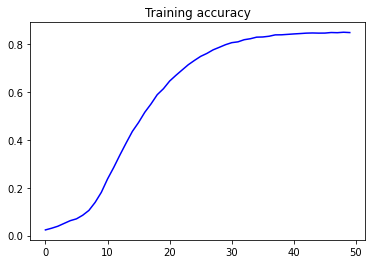

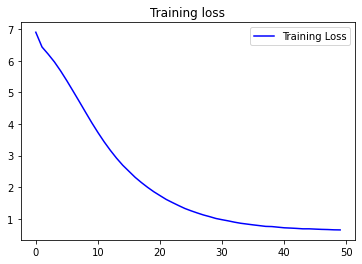

In [7]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()


In [8]:

#outcome of the seed text without - with learning rate chosen for Adam optimizer 
seed_text = "love thy foe as thy sweet not cruel"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

love thy foe as thy sweet not cruel out doth give bequest grief chase bequest bequest particulars are his slavery diest strife strife taken strife strife seen torture stewards of thee nor me you have i gone say thee not show her wrong you you so bad it was in me tend you call thee ' this live be well can tend tend tend seen pleasure thee ' his wealth chase thee can thou dost mistress common free slavery me tend kind knows anew of way eyes see it is writ in others they be none none on seen eyes seen night of woe might have lie of


Not an interesting text generation because of repetition of words. Looks like the model is trying to get the context and generate words, because it generated words like: woe, show her wrong you, strife, etc, but at the same time the context more suitable to slavery than what's given in the seed text. The next step could be to improve the capacity of the model tpo perform better.